In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def smoothen(waypoints):
    optimumpointlist = []
    i = 0
    range_factor = 6
    avg_factor = 2 * range_factor + 1
    num_of_waypoints = len(waypoints)

    for point in waypoints:
        counter = 0
        estimated_x_cord = point[0]
        estimated_y_cord = point[1]
        while counter < range_factor:
            estimated_x_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][0]
            estimated_x_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][0]

            estimated_y_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][1]
            estimated_y_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][1]
            counter += 1

        estimated_x_cord = estimated_x_cord / avg_factor
        estimated_y_cord = estimated_y_cord / avg_factor


        optimumpointlist.append(np.array( (estimated_x_cord, estimated_y_cord) ))

        i += 1
    return np.array(optimumpointlist)

In [3]:
def calc_distance(prev_point, next_point):
    delta_x = next_point[0] - prev_point[0]
    delta_y = next_point[1] - prev_point[1]
    return math.hypot(delta_x, delta_y)

def smooth_central_line(center_line, max_offset, pp=0.10, p=0.05, c=0.70, n=0.05, nn=0.10, iterations=72, skip_step=1):
    if max_offset < 0.0001:
        return center_line
    if skip_step < 1:
        skip_step = 1
    smoothed_line = center_line
    for i in range(0, iterations):
        smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
    return smoothed_line


def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
    length = len(center_line)
    new_line = [[0.0 for _ in range(2)] for _ in range(length)]
    for i in range(0, length):
        wpp = smoothed_line[(i - 2 * skip_step + length) % length]
        wp = smoothed_line[(i - skip_step + length) % length]
        wc = smoothed_line[i]
        wn = smoothed_line[(i + skip_step) % length]
        wnn = smoothed_line[(i + 2 * skip_step) % length]
        new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
        new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
        while calc_distance(new_line[i], center_line[i]) >= max_offset:
            new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
            new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
    return new_line

In [4]:
TRACK_NAME = 'C:/Users/suraj/projects/deepracer24/2022_may_open_ccw.npy'

# Load the center, inner, outer waypoints
waypoints = np.load(TRACK_NAME)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [5]:
1.066*0.6*0.5

0.31980000000000003

In [6]:
# smooth_path = smoothen(center_line)
smooth_path = smooth_central_line( center_line, 1.066*0.45*0.5,skip_step=1 )
smooth_path_45 = smooth_central_line( center_line, 1.066*0.45*0.5,skip_step=1 )
smooth_path = np.array( [ np.array(point) for point in smooth_path ] )
smooth_path_45 = np.array( [ np.array(point) for point in smooth_path_45 ] )
# smooth_path = up_sample(smooth_path, 10)

In [7]:
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead

In [8]:
# optimal_speeds, tp, angleChange = optimalSpeed()
optimal_velocity_ = optimal_velocity(smooth_path, 1.25, 4.0, 5 )

Constant multiple for optimal speed: 1.452221318223697


In [36]:
import pandas as pd

data = pd.read_csv('C:/Users/suraj/projects/deepracer24/deepracer-log-guru/033/training_data.csv')
status_col = 'episode_status' if 'episode_status' in data.columns else 'status'
data = data[data[status_col].isin(['in_progress', 'on_track'])]
data.rename(columns={'X':'x', 'Y':'y', 'yaw':'heading', 'steer':'steering_angle', 'throttle':'speed', 'closest_waypoint': 'closest_waypoints'}, inplace=True)
data['is_offtrack'] = ~data['on_track']
data['is_crashed'] = False
data = data[['x', 'y', 'heading', 'speed', 'steering_angle', 'progress', 'closest_waypoints', 'steps', 'is_offtrack', 'is_crashed']]
data.shape

(33717, 10)

In [37]:
# data = data[data['is_offtrack']==True]
data.shape

(33717, 10)

In [38]:
def get_params(row_number):
    params = data.iloc[row_number].to_dict()
    params['closest_waypoints'] = [ params['closest_waypoints'], params['closest_waypoints']+1 ]
    # print(params)

    params['waypoints'] = list( [list(point) for point in center_line] )
    params['track_width'] = 1.067
    params['is_reversed'] = False

    return params

In [45]:
from reward_function import reward_function, Path, Utils, SpeedUtils

In [40]:
params = get_params(805)
print(params)
print( reward_function( params ) )

{'x': 0.7353, 'y': 5.3888, 'heading': 172.424, 'speed': 2.5, 'steering_angle': 0, 'progress': 2.2663, 'closest_waypoints': [28, 29], 'steps': 7, 'is_offtrack': False, 'is_crashed': False, 'waypoints': [[5.047713151170359, 0.7338535442132044], [5.04770565032959, 0.8638535439968109], [5.0476956834520985, 0.9938535436147392], [5.047682523727417, 1.1654984951019287], [5.047635078430176, 1.4671425223350525], [5.047637939453125, 1.7687879800796509], [5.047791957855225, 2.0704389810562134], [5.047592401504517, 2.3720779418945312], [5.046535491943359, 2.6736875772476196], [5.047996997833252, 2.9753825664520264], [5.054185152053833, 3.2772375345230103], [5.043642044067383, 3.578518033027649], [4.985517501831055, 3.873627543449402], [4.864901304244995, 4.149420976638794], [4.694380521774292, 4.397387504577637], [4.485466480255127, 4.614418983459473], [4.248257637023926, 4.800158500671387], [3.9890859127044678, 4.953978538513184], [3.7155709266662598, 5.080641984939575], [3.430908441543579, 5.179

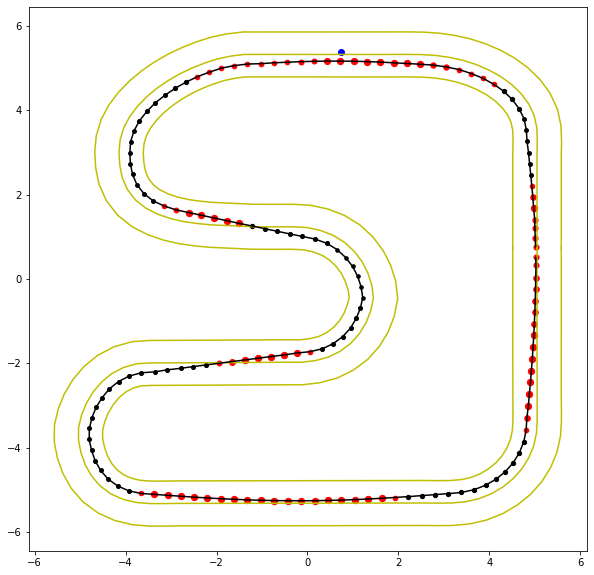

In [41]:
target = [-1.2972613775941606, -1.908002357052378]
plt.scatter(params['x'], params['y'], c = 'b')


plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'outer_border', c = 'k')
for i, point in enumerate(smooth_path):
    point = list(point)        
    plt.scatter(point[0], point[1], s = optimal_velocity_[i]*10, c = 'k' if optimal_velocity_[i]<2 else 'r')

# plt.scatter(target[0], target[1], c = 'g', s = 5)

plt.show()


In [67]:
rewards = []
for i in random.sample(range(0, len(data)), 50):
    params = get_params(i)
    rewards.append( reward_function( params ) )
    if i%50 == 0:
        print(i, ' rows done')
rewards_df = pd.DataFrame({'rewards':rewards})

steering_reward:  1.4690982012351954 distance_reward:  0.6970407893018369 speed_reward:  0.15684720828474685 total:  2.322986198821779
steering_reward:  1.495425076194157 distance_reward:  0.3256823612873947 speed_reward:  0.9736990372062964 total:  2.794806474687848
steering_reward:  0.990972464066325 distance_reward:  0.43139793117379566 speed_reward:  0.6034673525807557 total:  2.0258377478208764
steering_reward:  1.47439586326301 distance_reward:  0.7566357556668747 speed_reward:  0.9299842112306336 total:  3.1610158301605185
steering_reward:  1.4760962176140446 distance_reward:  0.32405107414145007 speed_reward:  0.9311452821324165 total:  2.7312925738879112
steering_reward:  0.964652093213289 distance_reward:  0.8975029142544861 speed_reward:  0.8865616194535311 total:  2.7487166269213064
steering_reward:  1.4531266426743608 distance_reward:  0.5664784078096519 speed_reward:  0.5272532790786282 total:  2.5468583295626406
steering_reward:  0.96875932695685 distance_reward:  0.7666

In [68]:
rewards_df.describe()

,rewards
count,50.000000
mean,2.180542
std,1.262593
min,-5.000000
25%,2.194735
50%,2.397880
75%,2.653592
max,3.161016


In [69]:
def normalize_reward(reward):
    old_value = reward
    old_min = 0.17
    old_max = 2.5
    new_min = -1
    new_max = 1
    new_value = ( (old_value - old_min) / float(old_max - old_min) ) * (new_max - new_min) + new_min
    return new_value

# rs = [normalize_reward(r) for r in compare_df['new'].tolist()]
normalize_reward(3.5)

1.8583690987124464

In [70]:
y = lambda x: ( 1/( (1+float(abs(x)) ) ) - 0.25 ) * 1.3333333

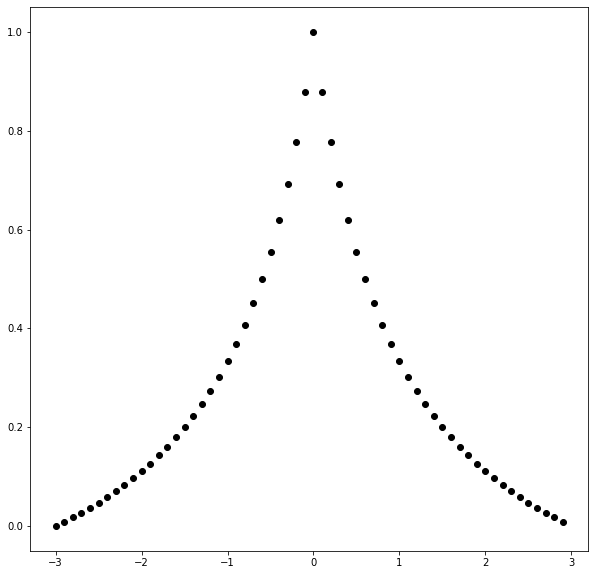

In [71]:
for i in range(-30, 30):
    x = i/10
    plt.scatter(x, y(x),c='k')
    # plt.scatter(x, 1 - abs(x/60), c='b')
plt.show()

In [72]:
# print(max(1-abs(0.8), 1e-3))
y(1.5)

0.19999999500000004

In [73]:
optimal_speed_penalty = lambda diff, optimal_speed: max(0, 1 - abs(diff) / optimal_speed)

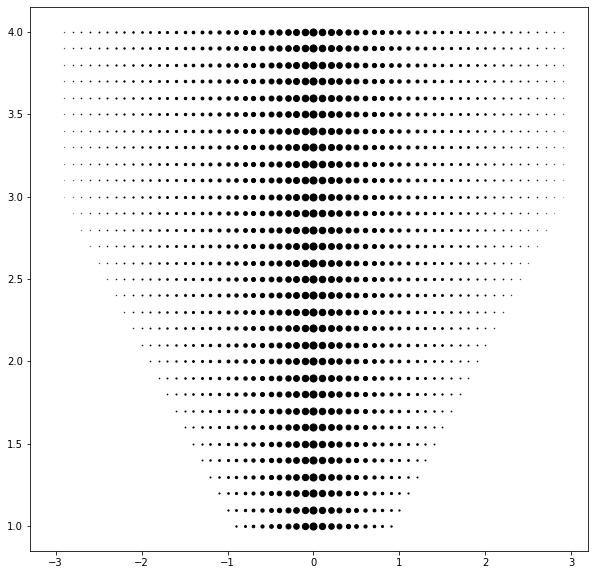

In [74]:
for diff in range(-30, 30):
    diff = diff/10
    for optimal_velocity in range(10, 41):
        optimal_velocity = optimal_velocity/10
        penalty = optimal_speed_penalty(diff, optimal_velocity)
        
        reward = y(diff) * penalty
        plt.scatter(diff, optimal_velocity, s = reward*50 , c = 'k')
plt.show()

In [75]:
sp = Path(center_line).get()

In [76]:
closest = Path(center_line).closest((params['x'], params['y']), 2)
prev = closest[0]
nex = closest[1]

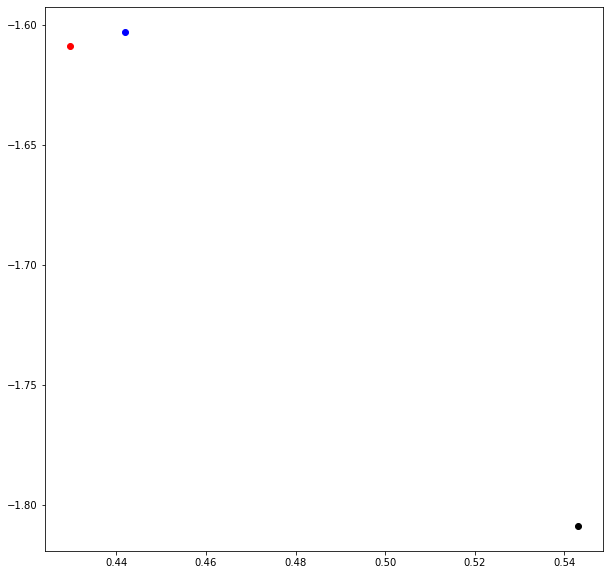

In [77]:
plt.scatter(params['x'], params['y'], c = 'k')
plt.scatter(prev[0], prev[1], c = 'b')
plt.scatter(nex[0], nex[1], c = 'r')
plt.show()

In [78]:
Utils.distanceFromLine(prev, nex, (params['x'], params['y']))

0.22943080917732178

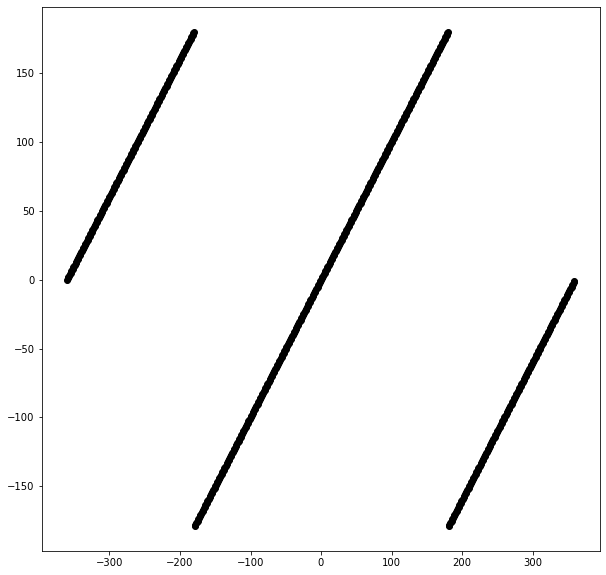

In [79]:
for angle in range(-360, 360):
    plt.scatter(angle, Utils.normalize_angle(angle), c = 'k')
plt.show()

In [80]:
from reward_function import Utils

Utils.normalize_angle( Utils.angle_between_points( (1, 1), (0, 0) ) - 135 ) - -45

135.0